In [48]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
import shap


In [49]:
df = pd.read_csv(r'C:\Users\NickBowen\Projects\NFL Data Project\Game Data\NFL_TeamGame_Stats2024 - Sheet1.csv')

In [50]:
# Split the data into features and target
X = df.drop(['Points','Week','Win/Loss','Team','Opponent','Opponent Points'], axis=1)
y = df['Points']

In [51]:
# Define categorical columns after dropping the specified columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [52]:
#create dictionary with models i want to loop through

# Define individual models
ridge_model = Ridge()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Create VotingRegressor model
ensemble_model = VotingRegressor([('ridge', ridge_model), ('rf', rf_model)])

# Create dictionary with models to loop through
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Polynomial Regression': Pipeline([
        ('poly_features', PolynomialFeatures(degree=2)),
        ('linear_regression', LinearRegression())
    ]),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'Voting Regressor': ensemble_model
}

In [53]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# Create a column transformer for one-hot encoding and imputation
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent value
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # Ignore unknown categories
        ]), categorical_cols),
        ('num', SimpleImputer(strategy='mean'), X.select_dtypes(include=['float64', 'int64']).columns)  # Impute missing values with the mean for numerical columns
    ],
    remainder='passthrough'  # Keep the rest of the columns unchanged
)

c:\Users\NickBowen\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\NickBowen\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\NickBowen\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\NickBowen\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\NickBowen\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:17

                            MAE        MSE        R2      MAPE
Linear Regression      4.593064  37.625644  0.511530  0.332349
Ridge Regression       3.964835  26.956787  0.650037  0.273764
Lasso Regression       4.371162  29.409424  0.618196  0.227321
Polynomial Regression  5.526560  43.262667  0.438348  0.403403
Decision Tree          5.050000  38.350000  0.502126  0.218460
Random Forest          4.308000  32.966260  0.572020  0.340965
Gradient Boosting      4.149763  29.524946  0.616696  0.344644
XGBoost                4.232513  29.590157  0.615849  0.351528
Voting Regressor       3.664367  24.619650  0.680378  0.281968


c:\Users\NickBowen\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


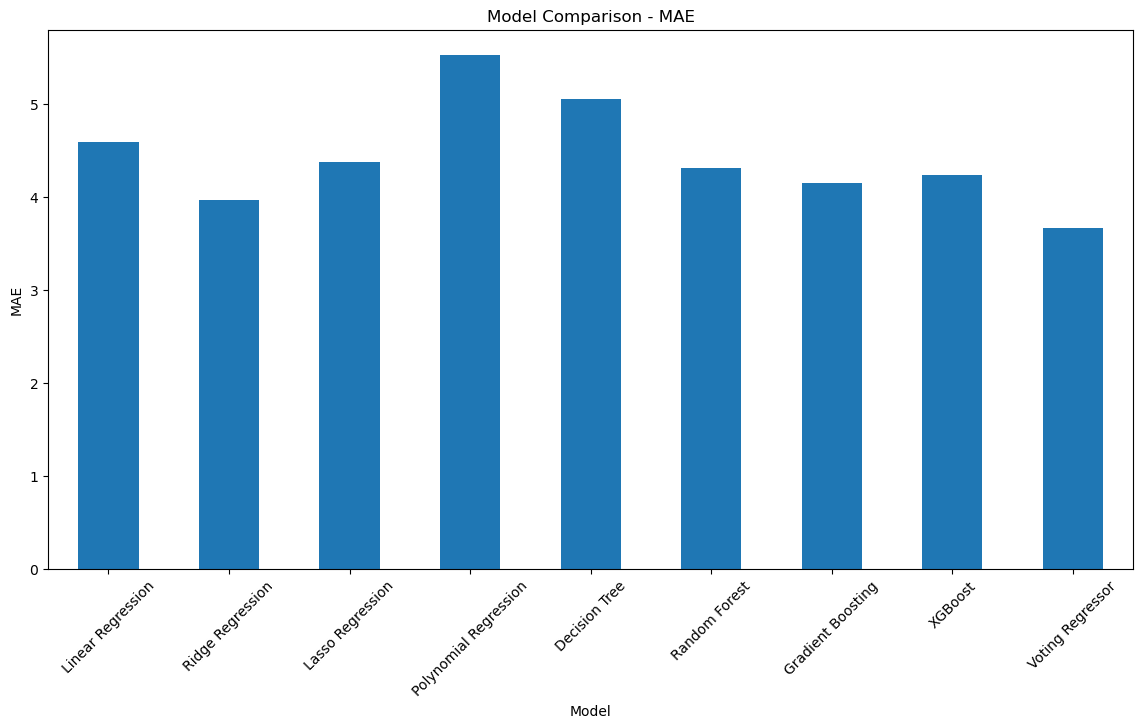

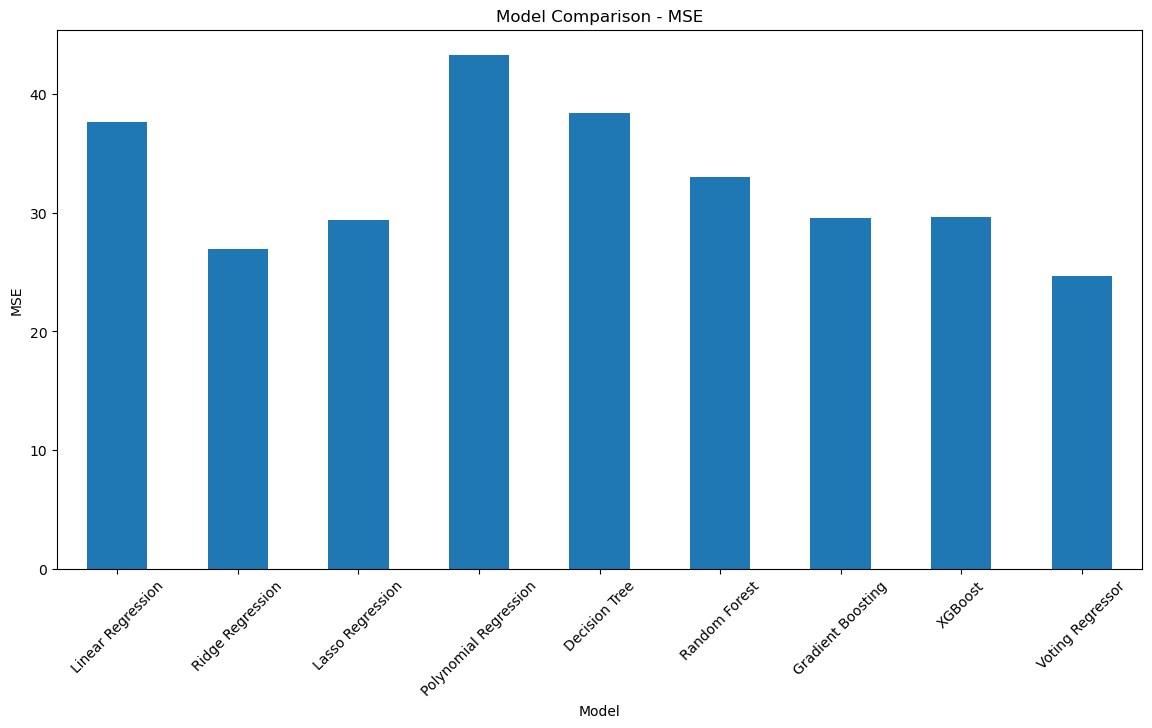

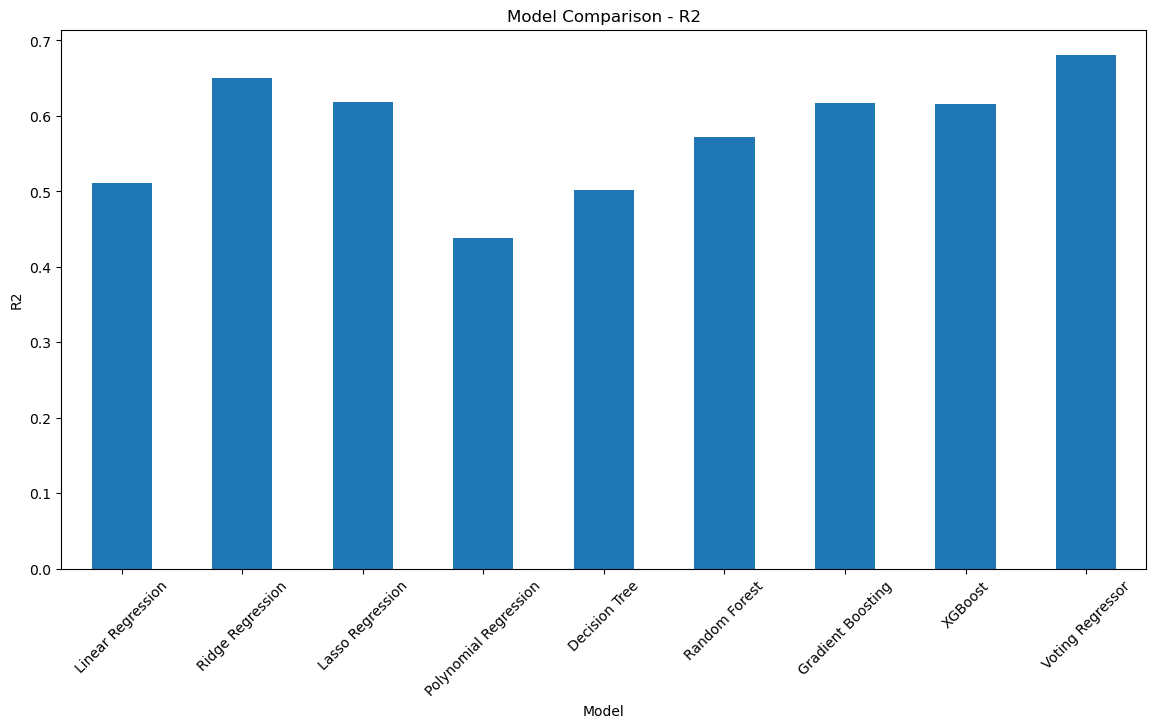

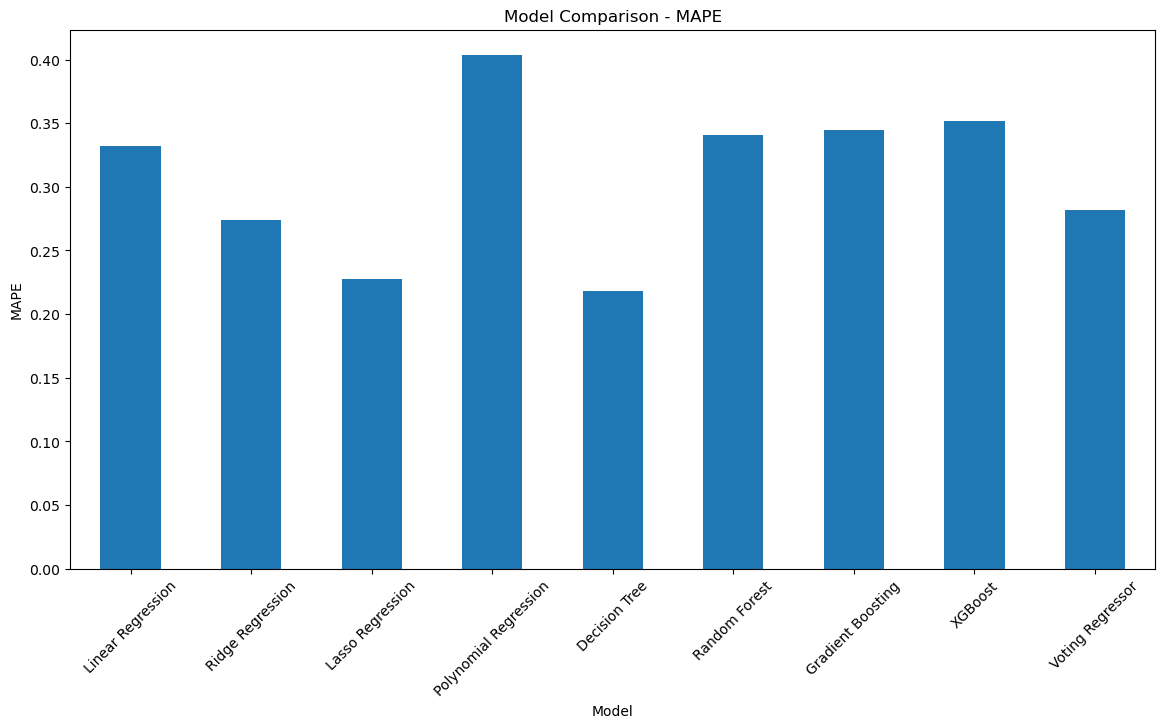

In [55]:
# Initialize results dictionary
results = {}

# Loop through models
for name, model in models.items():
    # Create a pipeline with preprocessing and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate performance metrics
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred)
    }

# Convert the results dictionary to a DataFrame for easier comparison
results_df = pd.DataFrame(results).T

# Display the results
print(results_df)

# Plot each performance metric in its own chart
metrics = results_df.columns

for metric in metrics:
    plt.figure(figsize=(14, 7))
    results_df[metric].plot(kind='bar')
    plt.title(f'Model Comparison - {metric}')
    plt.ylabel(metric)
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.show()